In [11]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib notebook

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 6))
mpl.rc('image', cmap='gray')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
from scipy.optimize import curve_fit

import pims
import trackpy as tp

frames = pims.ImageSequence("tiffile folder/*.tif")
frames

<Frames>
Source: C:\Users\HP\Desktop\M2 STAGE\Exp5-210325-AX2\210325_AX2_0,2pcO2_4x_dt_30_sec_1\Pos0\*.tif
Length: 180 frames
Frame Shape: (2160, 2560)
Pixel Datatype: uint16

<IPython.core.display.Javascript object>


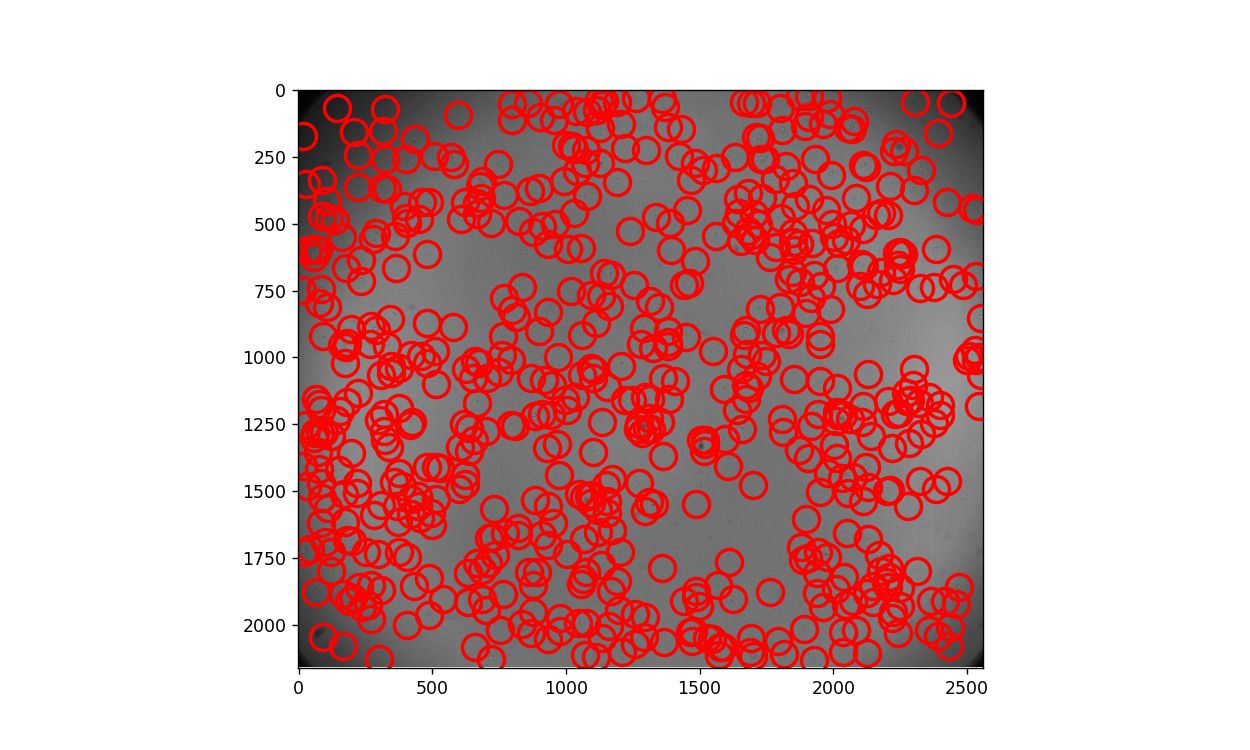

In [12]:
#OK if false cells are detected at this stage//filtering will be done
plt.imshow(frames[0]);

In [13]:
f = tp.locate(frames[0], 11, minmass=4757) #first filter is applied (frames, cell avgsize, min integrated brightness)

In [14]:
len(f)

617

In [15]:
tp.annotate(f, frames[0]); #compare with initial image, it takes some trial and error. Use find maxima in ImageJ for reference.

In [16]:
f = tp.batch(frames, 11, minmass=4757)

Frame 179: 682 features


In [17]:
t = tp.link(f, 5, memory=5)   #specify a maximum displacement, the farthest a particle can travel between frames
                             #memory is how long a particle is tracked after having left the borders in a frame  

Frame 179: 682 trajectories present.


In [18]:
t.mass.max()

57942.401535068304

In [19]:
t1 = tp.filter_stubs(t, 5)    #filter_stubs keeps only trajectories that last for a given number of frames
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 6399
After: 2893


In [20]:
t2 = t1[((t1['mass'] < 40000) & (t1['size']<2.45))] #filter t1 by excluding irregularities

<IPython.core.display.Javascript object>


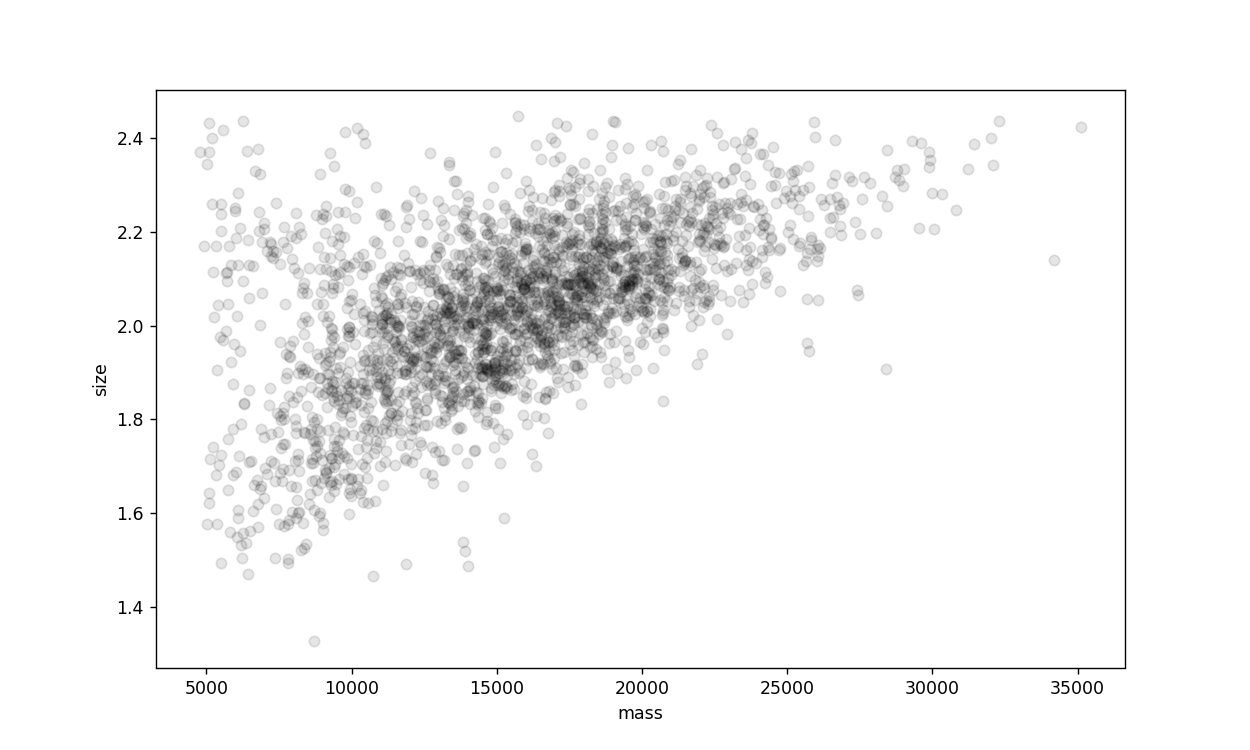

In [21]:
plt.figure()
tp.mass_size(t2.groupby('particle').mean()); 

In [22]:
t2 = t1[((t1['mass'] < 40000) & (t1['size']<2.45))]

<IPython.core.display.Javascript object>


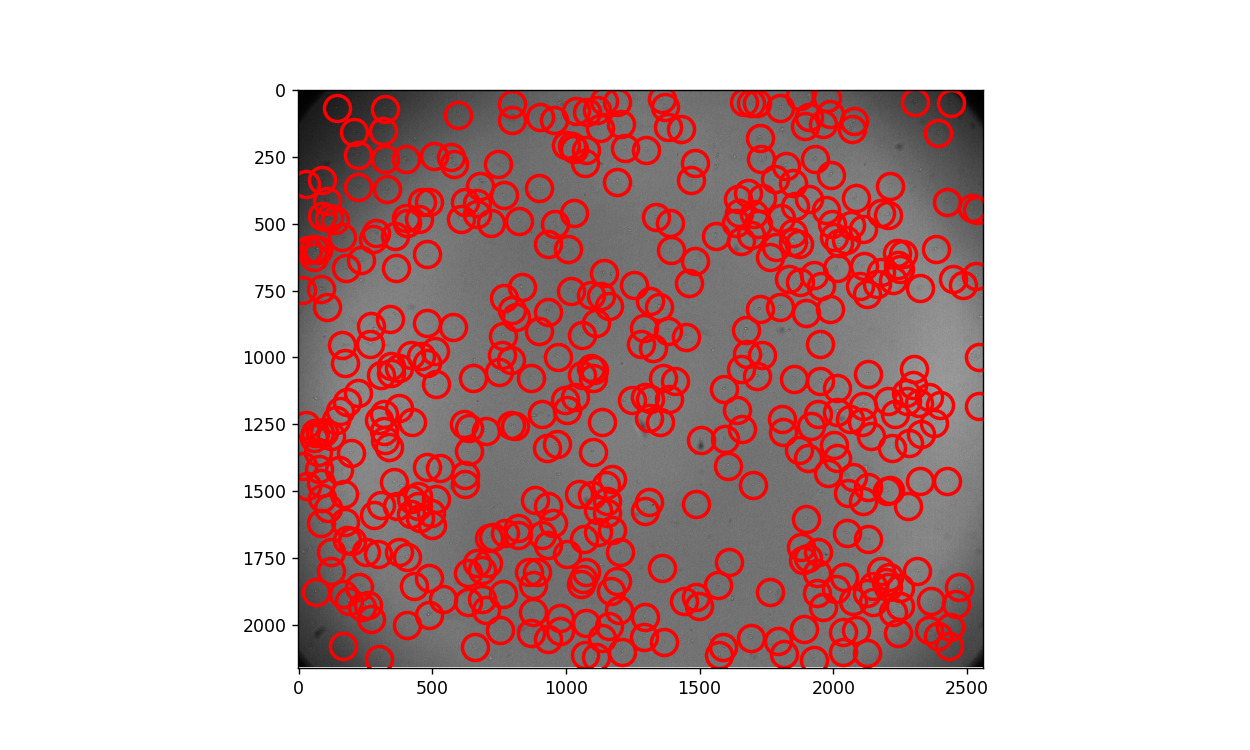

In [23]:
plt.figure()
tp.annotate(t2[t2['frame'] == 0], frames[0]);  #after all the filtering, these are the particles in FRAME i kept

<IPython.core.display.Javascript object>


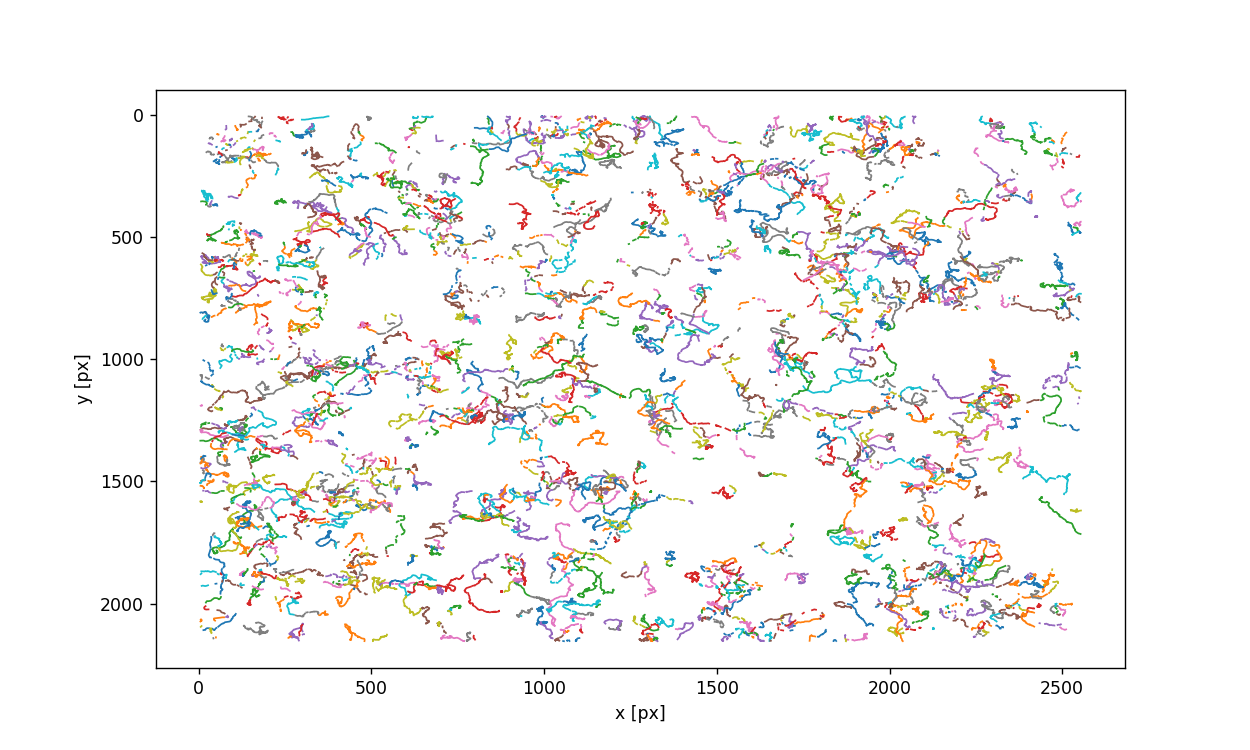

In [24]:
plt.figure()
tp.plot_traj(t2);

In [25]:
d = tp.compute_drift(t2)

<IPython.core.display.Javascript object>


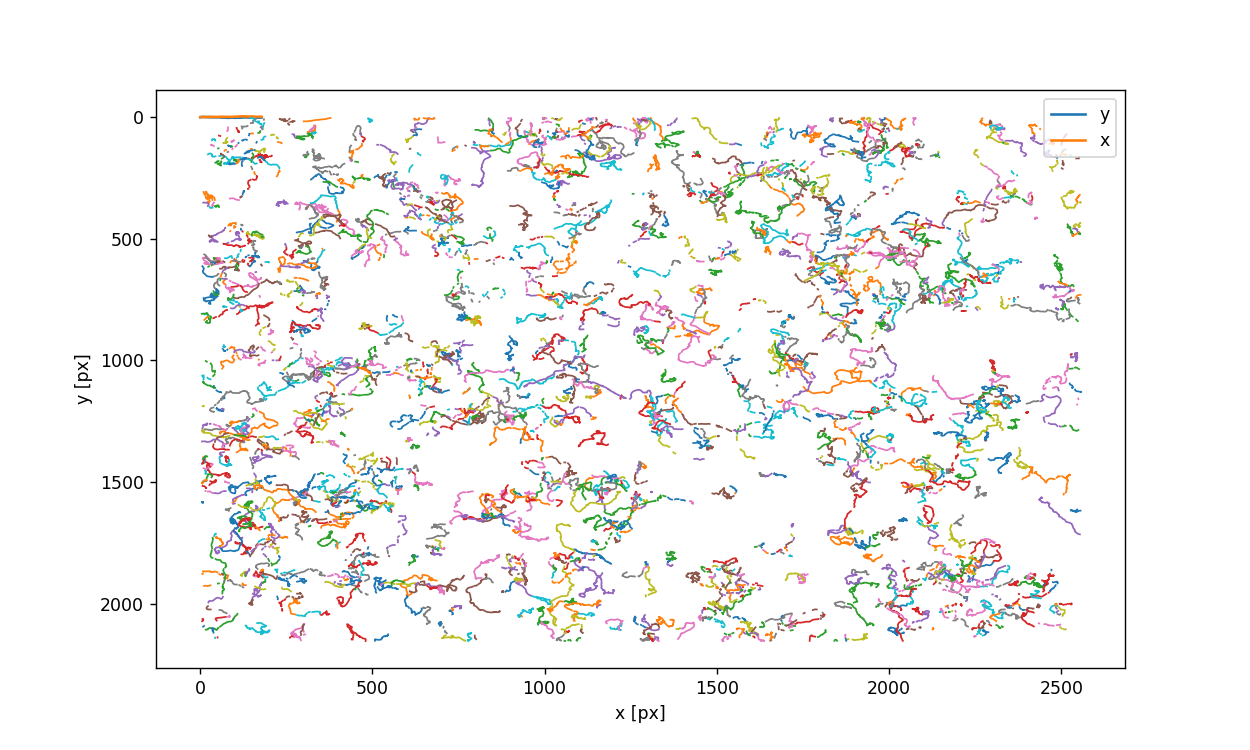

In [26]:
d.plot()
plt.show()

In [27]:
tm = tp.subtract_drift(t2.copy(), d)

In [28]:
ax = tp.plot_traj(tm)
plt.show()

In [ ]:
#im = tp.imsd(tm, 1.634, 1/30)   #MSD OF EACH INDIVIDUAL CELL

In [ ]:
#fig, ax = plt.subplots()
#ax.plot(im.index, im, 'k-', alpha=0.1)  # black lines, semitransparent
#ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
#       xlabel='lag time $t$')
#ax.set_xscale('log')
#ax.set_yscale('log')

In [29]:
em = tp.emsd(tm, 1.634, 1/30, max_lagtime=181) #ENSEMBLE MSD

<IPython.core.display.Javascript object>


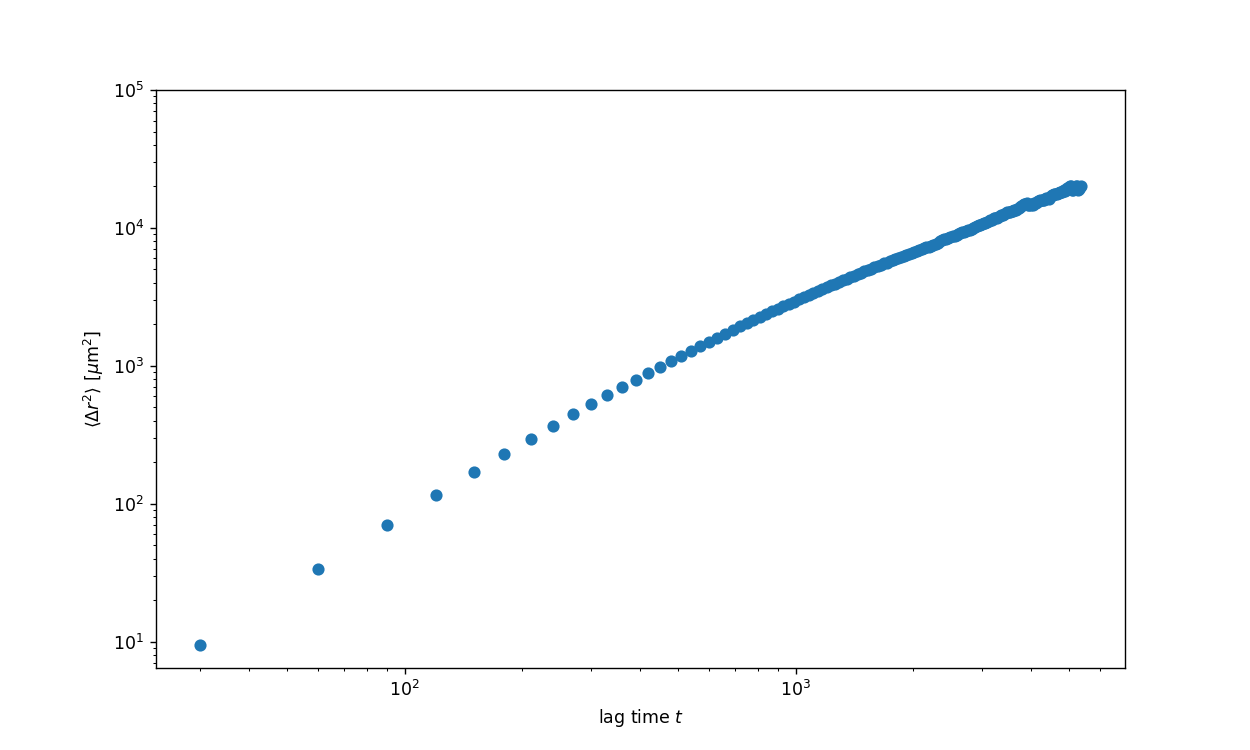

<ipython-input-30-d6e235c0a03a>:7: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(ylim=(0, 100000));


In [30]:
#RAW PLOT OF EXPERIMENTAL DATA

#fig, ax = plt.subplots()
#ax.plot(em.index, em, 'o')
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
#       xlabel='lag time $t$')
#ax.set(ylim=(0, 100000));

<IPython.core.display.Javascript object>


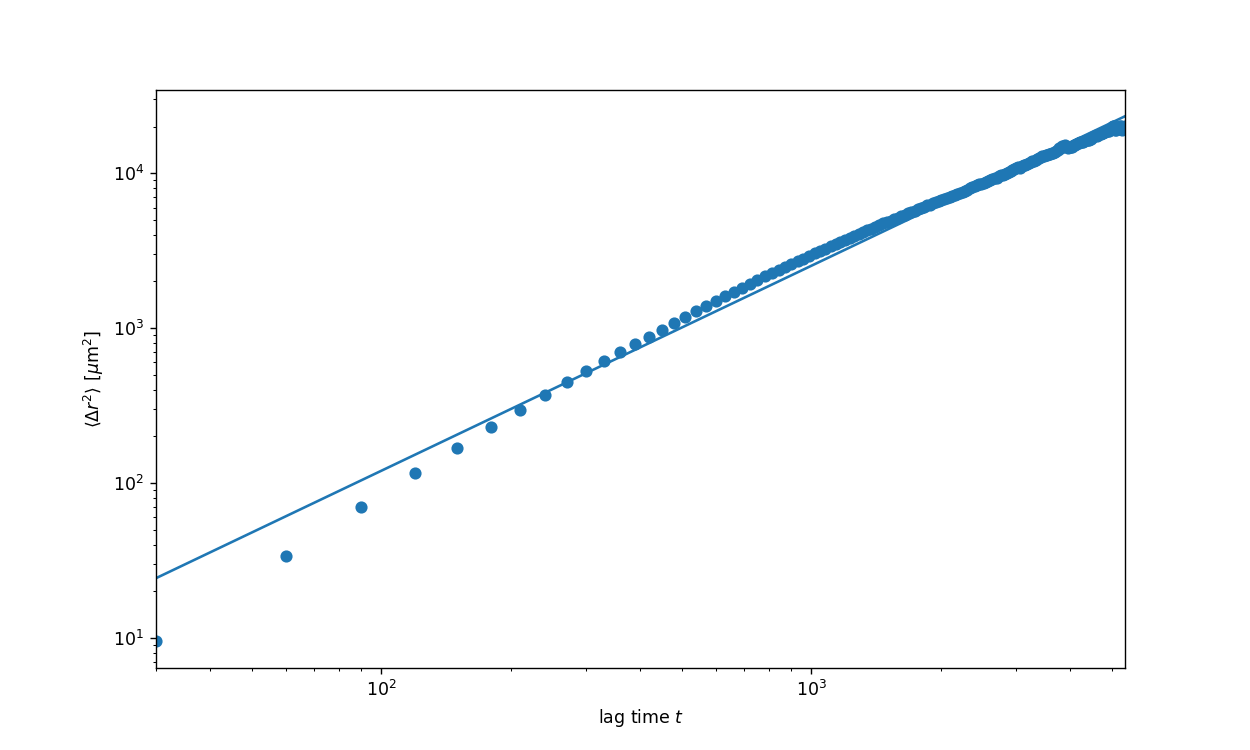

,n,A
msd,1.323074,0.270581


In [31]:
#TRACKPY'S LINEAR REGRESSION FIT; Rather avoid it; not enough control of sensitive parameters ; can skew information

#plt.figure()
#plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
#plt.xlabel('lag time $t$');
#tp.utils.fit_powerlaw(em) 

<IPython.core.display.Javascript object>


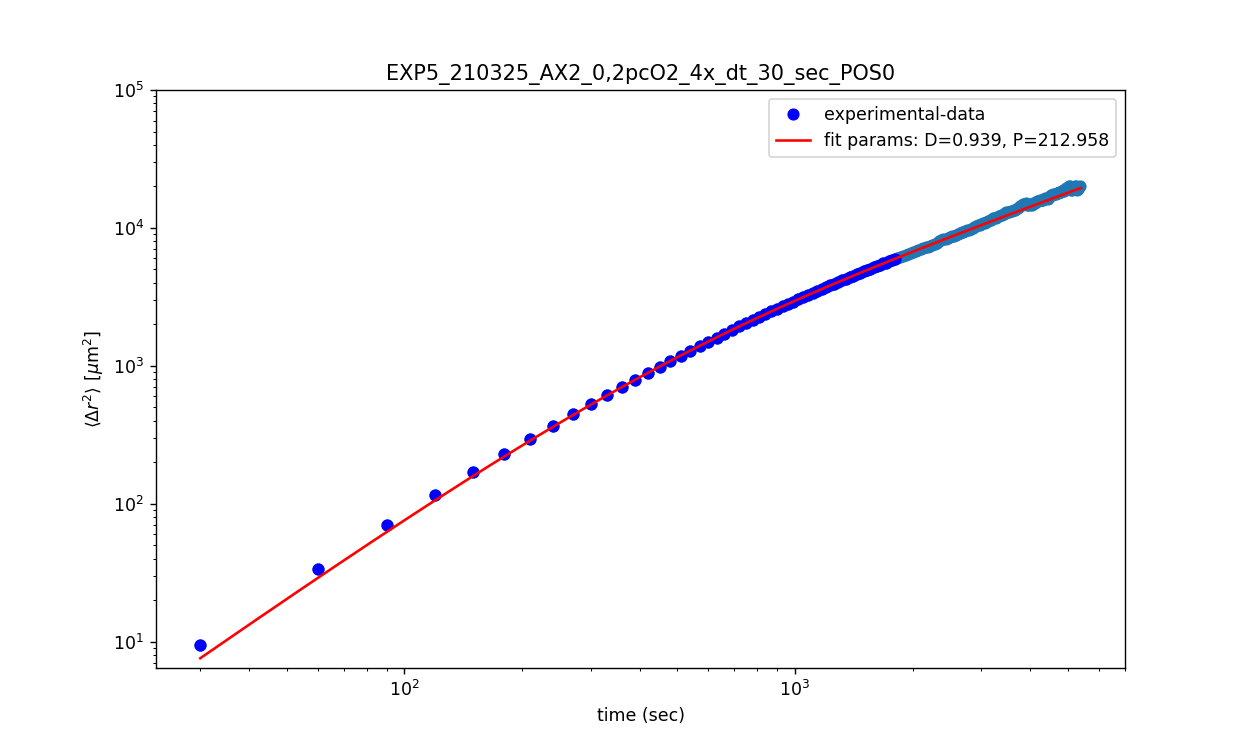

<ipython-input-32-d6e235c0a03a>:7: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(ylim=(0, 100000));


In [32]:
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set(ylim=(0, 100000));

In [33]:
#Fitting Furth function
def func(t, D, P):
    return 4*D*(t-P*(1-(np.exp(-(t/P)))))
    #return a*x+b
 
#Experimental x and y data points    
xData = em.index[0:60]
yData = em[0:1830]

#Plot experimental data points
plt.plot(xData, yData, 'bo', label='experimental-data')
 
# Initial guess for the parameters
#initialGuess = [1.0,1.0]    
 
#Perform the curve-fit
popt, pcov = curve_fit(func, xData, yData)#, initialGuess)
print(popt)
 
#x values for the fitted function
xFit = np.arange(30, (len(frames)*30), 0.01)
 
#Plot the fitted function
plt.plot(xFit, func(xFit, *popt), 'r', label='fit params: D=%5.3f, P=%5.3f' % tuple(popt))

plt.xlabel('time (sec)')
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.title('TITLE')
plt.legend()
plt.show()
#plt.ylim(0.5, (len(frames)*30));


[  0.93905793 212.95840835]


In [34]:
len(em.index)

179

<IPython.core.display.Javascript object>


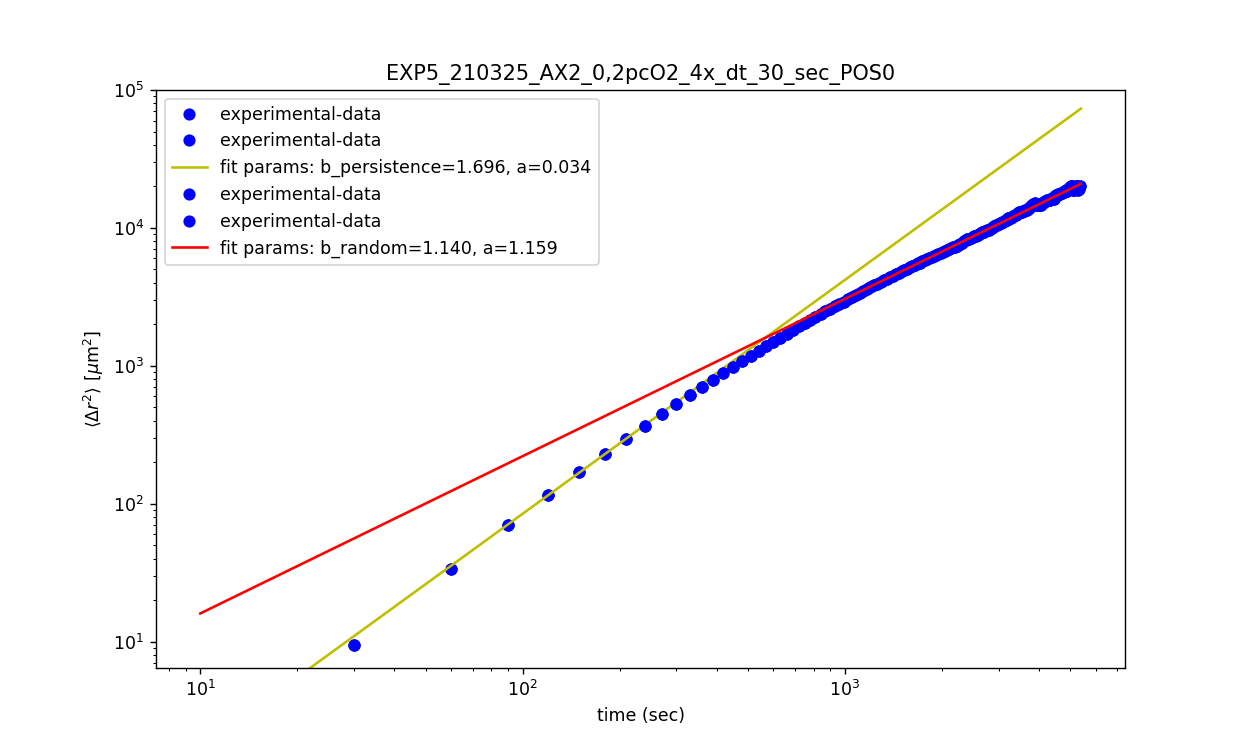

<ipython-input-35-d6e235c0a03a>:7: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set(ylim=(0, 100000));


In [35]:
fig, ax = plt.subplots()
ax.plot(em.index, em, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set(ylim=(0, 100000));

In [37]:
#Fitting Power Law with more control 
def func(t, b, a):
    return a*(t**(b))
    #return a*x+b
 
#Experimental x and y data points    
xData = em.index[:7]
yData = em[:215]

#Plot experimental data points
plt.plot(xData, yData, 'bo', label='experimental-data')
 
# Initial guess for the parameters
#initialGuess = [1.0,1.0]    
 
#Perform the curve-fit
popt, pcov = curve_fit(func, xData, yData)#, initialGuess)
print(popt)
 
#x values for the fitted function
xFit = np.arange(10, (len(frames)*30), 0.01)
 
#Plot the fitted function
plt.plot(xFit, func(xFit, *popt), 'y', label='fit params: b_persistence=%5.3f, a=%5.3f' % tuple(popt))

plt.xlabel('time (sec)')
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.title('EXP5_210325_AX2_0,2pcO2_4x_dt_30_sec_POS0')
plt.legend()
plt.show()

[1.69608149 0.03424694]


In [39]:
#Experimental x and y data points    
xData = em.index[7:]
yData = em[215:]

#Plot experimental data points
plt.plot(xData, yData, 'bo', label='experimental-data')
 
# Initial guess for the parameters
#initialGuess = [1.0,1.0]    
 
#Perform the curve-fit
popt, pcov = curve_fit(func, xData, yData)#, initialGuess)
print(popt)
 
#x values for the fitted function
xFit = np.arange(10, (len(frames)*30), 0.01)
 
#Plot the fitted function
plt.plot(xFit, func(xFit, *popt), 'r', label='fit params: b_random=%5.3f, a=%5.3f' % tuple(popt))

plt.xlabel('time (sec)')
plt.ylabel(r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]')
plt.title('EXP5_210325_AX2_0,2pcO2_4x_dt_30_sec_POS0')
plt.legend()
plt.show()

[1.14023598 1.15903905]


<IPython.core.display.Javascript object>


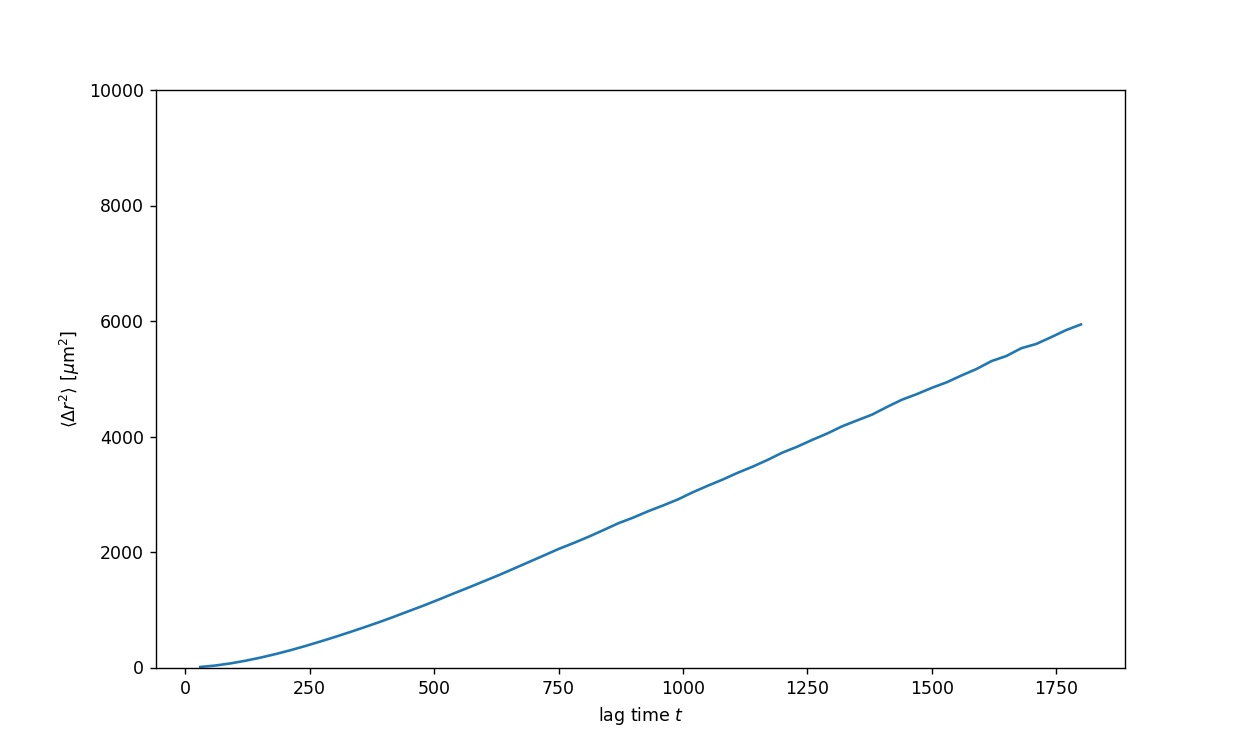

In [40]:
em_classic = tp.emsd(tm, 1.634, 1/30, max_lagtime=60)
fig, ax = plt.subplots()
ax.plot(em_classic.index, em_classic)#, 'o')
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.set(ylabel=r'$\langle \Delta r^2 \rangle$ [$\mu$m$^2$]',
       xlabel='lag time $t$')
ax.set(ylim=(0, 10000));

In [41]:
em_classic.head(60)

lagt
30.0         9.521987
60.0        33.863984
90.0        70.119966
120.0      115.910377
150.0      169.180104
180.0      229.554788
210.0      296.336376
240.0      368.907512
270.0      446.528789
300.0      526.694968
330.0      610.932157
360.0      697.663028
390.0      786.580261
420.0      881.072349
450.0      979.118414
480.0     1076.268823
510.0     1179.200655
540.0     1284.492404
570.0     1387.116451
600.0     1493.389962
630.0     1599.496315
660.0     1711.868543
690.0     1824.777269
720.0     1937.588003
750.0     2051.885219
780.0     2154.397008
810.0     2262.314333
840.0     2378.103368
870.0     2496.966928
900.0     2595.218004
930.0     2705.459367
960.0     2805.333404
990.0     2910.478759
1020.0    3034.936658
1050.0    3147.630455
1080.0    3254.705228
1110.0    3371.338061
1140.0    3477.319698
1170.0    3593.945712
1200.0    3721.130153
1230.0    3824.395909
1260.0    3941.895043
1290.0    4051.675381
1320.0    4176.563936
1350.0    4278.363247
1380.